In [1]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
p_col = "performance"# "performance_simulated","overall_performance","simulated"
cols = ["scenario","gsize","parameters","seed",p_col ]
scenarios =["A","B","C"]
gsizes = [5,50,500]
fpath = "simulated_data/"

clust_methods = ['k-means','B-k-means','MB-k-means', 
                 'HC', 'AP','BIRCH','DBSCAN',
                 'GMM','Spectral', 'MeanShift',  "mclust","NMF"] + ['sPCA','iCluster+', 'moCluster','MOFA2']
biclust_methods = ["QUBIC","ISA2","FABIA","COALESCE","BiMax","Plaid"]
method_order = ["UnPaSt"]+clust_methods+biclust_methods
print(len(method_order))
rename_methods = {"AffinityPropagation":"AP",
                 'HierarchicalClustering':"HC",
                  "BisectingKMeans":"B-k-means",
                  "MiniBatchKMeans":"MB-k-means",
                  "kmeans":"k-means",
                  "SpectralClustering":"Spectral",
                  "iClusterPlus":"iCluster+",
                  "sparse_PCA":"sPCA"
                  
                 }
group_colors = {"UnPaSt":'#ff0000',"clustering":'#0173b2',"biclustering":'#de8f05'}


# table to store parameter combinations: 
param_table = {}

23


# Simulated data bechmark

In [3]:
dfs = []
for fname in os.listdir(fpath):
    method = fname.replace("_ABC.tsv","")
    if method in rename_methods.keys():
        method = rename_methods[method]
    df = pd.read_csv(fpath+fname,sep="\t")
    df = df.dropna(subset=["parameters"])
    # fix parameters 
    df["parameters"] = df["parameters"].apply(lambda x: ";".join([p for p in x.split(";") if not p.startswith("random_state=")])) 
    if len(set(["performance_simulated","overall_performance"]).intersection(set(df.columns)))==2:
        df["performance"] = df["overall_performance"]
    if not "seed" in df.columns:
        if "run" in df.columns:
            print("run column is used instead of seed")
            df["seed"] = df["run"]
        else:
            df["seed"] = -1
    df2 = df.loc[:,cols].groupby(["parameters","scenario","gsize"]).agg("mean")
    
    df2.index = pd.DataFrame.from_records(df2.index).map(lambda x: str(x)).apply(lambda x: "@".join(x),axis=1)
    df2["parameters"] = [x.split("@")[0] for x in df2.index.values]
    df2  = df2.groupby(["parameters"]).agg("mean")
    best_p = df2.sort_values(p_col,ascending = False).head(1)[p_col].values[0]
    best_params = list(df2.loc[df2[p_col]==best_p,:].index.values)
    
    d = df.loc[df["parameters"]==best_params[0],cols]
    d["method"] = method
    dfs.append(d)
    
    # save to the table 
    best_params = "\n".join(sorted(best_params))
    param_table[method] = {"ABC_best":best_params}
    
dfs = pd.concat(dfs)
dfs

,scenario,gsize,parameters,seed,performance,method
189,A,5,k=4;max_iter=300;batch_size=1024;max_no_improv...,670487.0,0.000000,MB-k-means
532,A,5,k=4;max_iter=300;batch_size=1024;max_no_improv...,116739.0,0.000000,MB-k-means
865,A,5,k=4;max_iter=300;batch_size=1024;max_no_improv...,26225.0,0.000000,MB-k-means
1241,A,5,k=4;max_iter=300;batch_size=1024;max_no_improv...,777572.0,0.000000,MB-k-means
1544,A,5,k=4;max_iter=300;batch_size=1024;max_no_improv...,288389.0,0.000000,MB-k-means
...,...,...,...,...,...,...
3054,C,500,lambda_n=25;n_cluster=5;lambda_scale=1;iter_ma...,1.0,0.668618,iCluster+
3130,C,500,lambda_n=25;n_cluster=5;lambda_scale=1;iter_ma...,2.0,0.668618,iCluster+
3206,C,500,lambda_n=25;n_cluster=5;lambda_scale=1;iter_ma...,3.0,0.668618,iCluster+
3282,C,500,lambda_n=25;n_cluster=5;lambda_scale=1;iter_ma...,4.0,0.668618,iCluster+


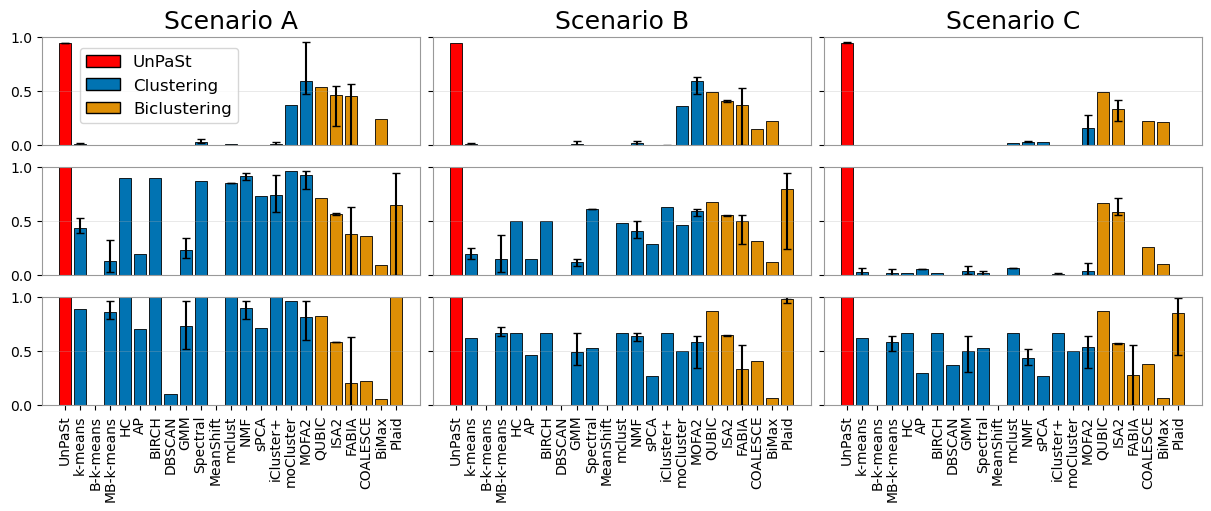

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_performance_grid_grouped(
    df: pd.DataFrame,             # data table
    clust_methods,                # list of clustering methods
    biclust_methods,              # list of biclustering methods
    group_colors,                  # dict like {"UnPaSt":"red","clustering":"blue","biclustering":"yellow"}
    scenarios=("A","B","C"),
    gsizes=(5,50,500),
    bar_width=0.8,
    ylabel="Performance",
    suptitle=None,
    fig_size=None,                # <-- NEW: set overall figure size, e.g. (12, 9)
    constrained=True              # <-- NEW: minimize margins around plots
):
    """
    df: DataFrame with columns ["method","scenario","gsize","performance","seed"]
    Only methods in {UnPaSt} ∪ clust_methods ∪ biclust_methods are plotted.
    Order within each subplot: [UnPaSt] + clustering methods + biclustering methods.
    """

    # --- validation ---
    needed_cols = {"method","scenario","gsize","performance","seed"}
    missing = needed_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = df[df["scenario"].isin(scenarios) & df["gsize"].isin(gsizes)].copy()
    df["gsize"] = df["gsize"].astype(int)

    # keep only the requested groups
    allowed = {"UnPaSt", *clust_methods, *biclust_methods}
    df = df[df["method"].isin(allowed)]

    # --- aggregate: mean & std across seeds for each (scenario,gsize,method) ---
    agg = (df
           .groupby(["scenario","gsize","method"], as_index=False)["performance"]
           .agg(mean="mean", min="min", max="max"))
    agg["err_low"]  = (agg["mean"] - agg["min"]).clip(lower=0)
    agg["err_high"] = (agg["max"] - agg["mean"]).clip(lower=0)

    def method_group(m):
        if m == "UnPaSt":
            return "UnPaSt"
        elif m in clust_methods:
            return "clustering"
        elif m in biclust_methods:
            return "biclustering"
        else:
            return "other"

    # --- figure & axes ---
    if fig_size is None:
        fig_w = 4.6 * len(scenarios)
        fig_h = 3.6 * len(gsizes)
        fig_size = (fig_w, fig_h)

    fig, axes = plt.subplots(
        nrows=len(gsizes), ncols=len(scenarios),
        figsize=fig_size,
        sharex=True, sharey=True,
        constrained_layout=constrained
    )
    if len(gsizes) == 1 and len(scenarios) == 1:
        axes = np.array([[axes]])
    elif len(gsizes) == 1:
        axes = np.array([axes])
    elif len(scenarios) == 1:
        axes = axes[:, np.newaxis]

    y_min, y_max = 0.0, 1.0

    # Pre-build legend handles (group legend)
    legend_handles = [
        Patch(facecolor=group_colors["UnPaSt"], edgecolor="black", label="UnPaSt"),
        Patch(facecolor=group_colors["clustering"], edgecolor="black", label="Clustering"),
        Patch(facecolor=group_colors["biclustering"], edgecolor="black", label="Biclustering"),
    ]

    for r, g in enumerate(gsizes):
        for c, s in enumerate(scenarios):
            ax = axes[r, c]
            sub = agg[(agg["gsize"] == g) & (agg["scenario"] == s)]
            
            
            # methods present in this subplot, ordered UnPaSt -> clustering -> biclustering
            ordered = ["UnPaSt"] + list(clust_methods) + list(biclust_methods)
            present = set(sub["method"].unique())
            methods_here = [m for m in ordered if m in present]

            # style: grey borders
            for spine in ax.spines.values():
                spine.set_edgecolor("0.6")

            sub = sub.set_index("method").reindex(methods_here)

            x = np.arange(len(methods_here))
            means = sub["mean"].values
            errs = np.vstack([sub["err_low"].values,
                  sub["err_high"].values]) 
            # hide error bars if err is 0
            mask = (sub["err_low"].values == 0) & (sub["err_high"] == 0)
            errs[:, mask] = np.nan

            colors = [group_colors[method_group(m)] for m in methods_here]

            ax.bar(x, means, yerr=errs, width=bar_width, capsize=3,
                   edgecolor="black", linewidth=0.6, color=colors)
            if g==5:
                ax.set_title(f"Scenario {s}", pad=6, fontsize=18) # , {g} genes
            #if s=="A":
            #    ax.set_ylabel(f"{g} genes", fontsize=18)

            # ticks: only bottom row has labels, and make them vertical
            ax.set_xticks(x)
            if r == len(gsizes) - 1:
                ax.set_xticklabels(methods_here, rotation=90, ha="center")
            else:
                ax.set_xticklabels([])
                ax.tick_params(axis="x", which="both", length=0)

            ax.grid(axis="y", linewidth=0.5, alpha=0.4)
            ax.set_ylim(y_min, y_max)

    # Put the legend *inside* the upper-left subplot
    axes[0, 0].legend(handles=legend_handles, loc=(0.1,0.2),
                      frameon=True, title="", fontsize=12)

    #if suptitle:
    #    fig.suptitle(suptitle)

    # If not using constrained layout, still tighten a bit
    if not constrained:
        plt.tight_layout()

    #plt.show()


# Example call (adjust to your vars):
plot_performance_grid_grouped(
    dfs,
    clust_methods=clust_methods,
    biclust_methods=biclust_methods,
    group_colors=group_colors,
    scenarios=("A","B","C"),
    gsizes=(5,50,500),
    ylabel="",
    suptitle="",
    fig_size=(12, 5),       # <— control figure size here
    constrained=True        # <— minimize margins
)

for ext in ["png","svg","pdf"]:
    plt.savefig("../../img/Fig3/Fig3a_v4."+ext,dpi = 300)

# Breast cancer benchmark  


### selectin parameters: 
* best for TCGA/METABRIC - lowest rank in one dataset
* optimal parameters - with lowest mean rank in TCGA and METABRIC

in case of ties the parameters closest to defaults are selected

In [5]:
p_col = "PAM50"
fpath = "real_data/"

def add_rank(df,p_col,suffix):
    df_ = df.loc[:,:].copy().dropna(subset=["parameters"])
    # fix parameters 
    df_["parameters"] = df_["parameters"].apply(lambda x: ";".join([p for p in x.split(";") if not p.startswith("random_state=")])) 
    df_ = df_.loc[:,[p_col,"parameters"]].groupby("parameters").agg("mean")
    df_["rank"] = df_[p_col].rank(ascending=False)
    df_ = df_.sort_values(by =p_col,ascending=False)
    df_.columns = [c+"_"+suffix for c in df_.columns]
    return df_

for method in sorted(set(["_".join(x.split("_")[:-1]) for x in os.listdir(fpath)])):
    fname1 = method+"_TCGA.tsv"
    fname2 = method+"_METABRIC.tsv"
    if method in rename_methods.keys():
        method = rename_methods[method]
    df1 = pd.read_csv(fpath+fname1,sep="\t",index_col=0)
    df2 = pd.read_csv(fpath+fname2,sep="\t",index_col=0)
    
    d1 = add_rank(df1,p_col,"TCGA")
    d2 = add_rank(df2,p_col,"METABRIC")
    shared_indexes = set(d1.index.values).intersection(set(d2.index.values))
    d = pd.concat([d1,d2.loc[sorted(shared_indexes),:]],axis=1)
    d["mean_rank"] = d["rank_TCGA"]+d["rank_METABRIC"]
    d["mean_rank"] = d["mean_rank"]*0.5
    best_mean_rank = d.sort_values("mean_rank").head(1)["mean_rank"].values[0]
    opt_params = d.loc[d["mean_rank"]==best_mean_rank].sort_values("mean_rank").index.values
    # save to the table 
    opt_params = "\n".join(sorted(opt_params))
    param_table[method].update({"breast_cancer_opt":opt_params})
    for ds in ["TCGA","METABRIC"]:
        best_rank = d.sort_values("rank_"+ds).head(1)["rank_"+ds].values[0]
        best_params = d.loc[d["rank_"+ds]==best_rank].sort_values("rank_"+ds).index.values
        best_params = "\n".join(sorted(best_params))
        param_table[method].update({ds+"_best":best_params})
    
    #print(method, d.shape[0])
    #print(opt_params)
    #print(d.loc[d["mean_rank"]==best_mean_rank].sort_values("mean_rank"))
    #print()

In [6]:
param_table = pd.DataFrame.from_dict(param_table).T
param_table = param_table.loc[["UnPaSt"]+clust_methods+biclust_methods,:]
param_table.to_csv("../../img/Fig3/param_table.tsv",sep="\t")


### read selected parameters from the table and plot the results

In [7]:
from openpyxl import load_workbook

# Load workbook
wb = load_workbook("param_table_selected.xlsx")
sheet = wb["S1b"]  # or wb["SheetName"]

# Extract values
data = sheet.values

# First row as header
columns = next(data)
param_table2 = pd.DataFrame(data, columns=columns).dropna()
param_table2.set_index("method",inplace=True)
param_table2

,default,ABC_best,breast_cancer_optimized,TCGA_best,METABRIC_best
method,,,,,
UnPaSt,bin=kmeans;pval=0.01;direction=UP-DOWN;clust=W...,bin=GMM;pval=0.05;direction=UP-DOWN;clust=WGCN...,bin=kmeans;pval=0.01;direction=UP-DOWN;clust=W...,bin=ward;pval=0.01;direction=UP-DOWN;clust=WGC...,bin=kmeans;pval=0.05;direction=UP-DOWN;clust=W...
k-means,k=?;max_iter=300;init=k-means++;tol=0.0001,k=3;max_iter=300;init=k-means++;tol=0.0001,k=3;max_iter=300;init=k-means++;tol=0.0001,k=3;max_iter=300;init=k-means++;tol=0.0001,\nk=4;max_iter=300;init=k-means++;tol=0.0001
B-k-means,k=?;max_iter=300;tol=0.0001;bisecting_strategy...,k=4;max_iter=300;tol=0.0001;bisecting_strategy...,k=8;max_iter=300;tol=0.0001;bisecting_strategy...,k=8;max_iter=300;tol=0.0001;bisecting_strategy...,k=5;max_iter=300;tol=0.0001;bisecting_strategy...
MB-k-means,k=?;max_iter=300;batch_size=1024;max_no_improv...,k=4;max_iter=300;batch_size=1024;max_no_improv...,k=4;max_iter=300;batch_size=500;max_no_improve...,k=4;max_iter=300;batch_size=500;max_no_improve...,k=5;max_iter=300;batch_size=100;max_no_improve...
HC,k=?;linkage=ward,k=5;linkage=ward,k=6;linkage=ward,k=6;linkage=ward,k=5;linkage=ward
AP,damping=0.5;max_iter=200,damping=0.9;max_iter=200,damping=0.97;max_iter=200,damping=0.99;max_iter=200,damping=0.95;max_iter=200
BIRCH,k=?;branching_factor=50;threshold=0.5,k=5;branching_factor=50;threshold=0.5,k=6;branching_factor=50;threshold=0.5,k=6;branching_factor=50;threshold=0.5,k=5;branching_factor=50;threshold=0.5
DBSCAN,eps=0.5;min_samples=5,eps=130;min_samples=3,eps=150;min_samples=5,eps=140;min_samples=20,eps=150;min_samples=5
GMM,covtype=full;initmethod=kmeans;k=?,covtype=diag;initmethod=kmeans;k=5,covtype=spherical;initmethod=kmeans;k=4,covtype=spherical;initmethod=kmeans;k=4,covtype=diag;initmethod=kmeans;k=4


### Fig. 3b - breast cancer, optimized parameters

In [8]:
dfs = []
for method in sorted(set(["_".join(x.split("_")[:-1]) for x in os.listdir(fpath)])):
    fname1 = method+"_TCGA.tsv"
    fname2 = method+"_METABRIC.tsv"
    df1 = pd.read_csv(fpath+fname1,sep="\t",index_col=0).loc[:,[p_col,"parameters"]].dropna(subset="parameters")
    df2 = pd.read_csv(fpath+fname2,sep="\t",index_col=0).loc[:,[p_col,"parameters"]].dropna(subset="parameters")
    df1["parameters"] = df1["parameters"].apply(lambda x: ";".join([p for p in x.split(";") if not p.startswith("random_state=")]))
    df2["parameters"] = df2["parameters"].apply(lambda x: ";".join([p for p in x.split(";") if not p.startswith("random_state=")]))
    if method in rename_methods.keys():
        method = rename_methods[method]
    # optimap parameters
    opt_params =  param_table2.loc[method,"breast_cancer_optimized"]
    d1 = df1.loc[df1["parameters"]==opt_params, [p_col,"parameters"]]
    d2 = df2.loc[df2["parameters"]==opt_params,[p_col,"parameters"]]
    d1["dataset"] = "TCGA-BRCA"
    d2["dataset"] = "METABRIC"
    d = pd.concat([d1,d2])
    d["method"] = method
    dfs.append(d)
dfs = pd.concat(dfs)
dfs

,PAM50,parameters,dataset,method
100,0.106384,damping=0.97;max_iter=200,TCGA-BRCA,AP
101,0.106384,damping=0.97;max_iter=200,TCGA-BRCA,AP
102,0.106384,damping=0.97;max_iter=200,TCGA-BRCA,AP
103,0.106384,damping=0.97;max_iter=200,TCGA-BRCA,AP
104,0.106384,damping=0.97;max_iter=200,TCGA-BRCA,AP
...,...,...,...,...
84,0.069035,n_components=16;alpha=1;ridge_alpha=0.1;max_it...,METABRIC,sPCA
204,0.069035,n_components=16;alpha=1;ridge_alpha=0.1;max_it...,METABRIC,sPCA
324,0.069035,n_components=16;alpha=1;ridge_alpha=0.1;max_it...,METABRIC,sPCA
444,0.069035,n_components=16;alpha=1;ridge_alpha=0.1;max_it...,METABRIC,sPCA


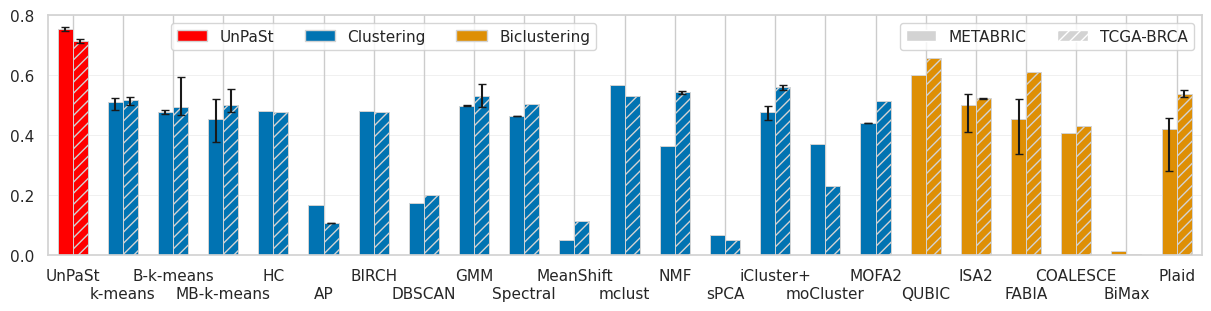

In [9]:
def plot_dual_dataset_bars(
    dfs: pd.DataFrame,                 # columns: method, dataset, PAM50 (replicates allowed)
    clust_methods,                     # list of clustering methods
    biclust_methods,                   # list of biclustering methods
    dataset_order = ("TCGA-BRCA","METABRIC"),
    group_colors = {"UnPaSt":"red","clustering":"blue","biclustering":"yellow"},
    fig_size = (12, 6),
    ylim = (0, 1),
    bar_width = 0.3,
    ylabel = "Performance",
    p_col = "PAM50",
    title = None
):
    # --- validation ---
    needed = {"method", "dataset", p_col}
    missing = needed - set(dfs.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    if len(dataset_order) != 2:
        raise ValueError("dataset_order must contain exactly two dataset names.")

    d1, d2 = dataset_order

    # keep only the two datasets
    df = dfs[dfs["dataset"].isin([d1, d2])].copy()
    if df.empty:
        raise ValueError("No rows found for the specified dataset_order.")

    # method -> group
    def method_group(m):
        if m == "UnPaSt":
            return "UnPaSt"
        elif m in clust_methods:
            return "clustering"
        elif m in biclust_methods:
            return "biclustering"
        else:
            return None

    df["__group__"] = df["method"].map(method_group)
    df = df[df["__group__"].notna()].copy()
    if df.empty:
        raise ValueError("After filtering to declared groups, no methods remain to plot.")

    # aggregate across replicates per (method, dataset)
    agg = (df.groupby(["method", "dataset"], as_index=False)[p_col]
             .agg(mean="mean", min="min", max="max"))

    # method order: UnPaSt, then clustering (as given), then biclustering
    methods_present = list(agg["method"].unique())
    def in_df(m): return m in methods_present
    methods_here = []
    if in_df("UnPaSt"): methods_here.append("UnPaSt")
    methods_here += [m for m in clust_methods if in_df(m)]
    methods_here += [m for m in biclust_methods if in_df(m)]
    if not methods_here:
        raise ValueError("No methods to plot after aggregation.")

    # split by dataset & align to method order
    a1 = (agg[agg["dataset"] == d1].set_index("method").reindex(methods_here))
    a2 = (agg[agg["dataset"] == d2].set_index("method").reindex(methods_here))

    # compute asymmetric error distances
    def err_from(df_):
        mean = df_["mean"].astype(float)
        low  = (mean - df_["min"].astype(float)).clip(lower=0).values
        high = (df_["max"].astype(float) - mean).clip(lower=0).values
        # if both low & high are zero, mark no error
        mask = (low == 0) & (high == 0)
        yerr = np.vstack([low, high])
        yerr[:, mask] = np.nan
        return mean.values, yerr

    means1, yerr1 = err_from(a1)
    means2, yerr2 = err_from(a2)

    # positions & colors
    x = np.arange(len(methods_here))
    off = bar_width / 2.0
    colors = [group_colors[method_group(m)] for m in methods_here]

    # --- plot ---
    fig, ax = plt.subplots(figsize=fig_size, constrained_layout=True)

    # grey axis borders
    for spine in ax.spines.values():
        spine.set_edgecolor("lightgrey")
        
    # first (solid)
    bars1 = ax.bar(
        x - off, means1, yerr=yerr1, width=bar_width, capsize=3,
        edgecolor="lightgrey", linewidth=0.7, color=colors, label=d1
    )

    # sexond (striped, lightgrey hatches & borders)
    bars2 = ax.bar(
        x + off, means2, yerr=yerr2, width=bar_width, capsize=3,
        edgecolor="lightgrey", linewidth=0.7,
        color=colors, hatch="///", label=d2
    )

    # axes & ticks
    ax.set_ylim(*ylim)
    ax.set_ylabel(ylabel)
    ax.grid(axis="y", linewidth=0.5, alpha=0.4)

    # --- horizontal, checkerboard two-line labels ---
    ticklabels = [lbl if i % 2 == 0 else "\n" + lbl for i, lbl in enumerate(methods_here)]
    ax.set_xticks(x)
    ax.set_xticklabels(ticklabels, rotation=0, ha="center")

    # legends (no titles)
    ds_handles = [
        Patch(facecolor="lightgrey", edgecolor="white", label=d1),
        Patch(facecolor="lightgrey", edgecolor="white", hatch="///", label=d2),
    ]
    leg1 = ax.legend(handles=ds_handles, loc="upper right", frameon=True, title=None, ncol=2)
    ax.add_artist(leg1)

    group_handles = [
        Patch(facecolor=group_colors["UnPaSt"], edgecolor="lightgrey", label="UnPaSt"),
        Patch(facecolor=group_colors["clustering"], edgecolor="lightgrey", label="Clustering"),
        Patch(facecolor=group_colors["biclustering"], edgecolor="lightgrey", label="Biclustering"),
    ]
    # place horizontally with 3 columns, move slightly to the right
    ax.legend(
        handles=group_handles,
        loc="upper left",
        ncol=3,                         # <-- horizontal alignment
        bbox_to_anchor=(0.1, 1.0),     # <-- shift legend (x=0.05 means a bit right)
        frameon=True,
        title=None
    )
    if title:
        ax.set_title(title, pad=8)

    ax.set_xlim(-0.5, len(methods_here) - 0.5)
    #plt.show()
    
sns.set_theme(style="whitegrid")
plot_dual_dataset_bars(
    dfs,  # your dataframe with columns: method, dataset, PAM50
    clust_methods=clust_methods,
    biclust_methods=biclust_methods,
    dataset_order=("METABRIC","TCGA-BRCA"),#("METABRIC","TCGA-BRCA"),
    group_colors=group_colors,
    fig_size=(12, 3),
    ylim=(0, 0.8),
    ylabel=""
)
for ext in ["png","svg","pdf"]:
    plt.savefig("../../img/Fig3/Fig3b_v4."+ext,dpi = 300)

### Fig. 3c - asthma; two datasets, optimized parameters 

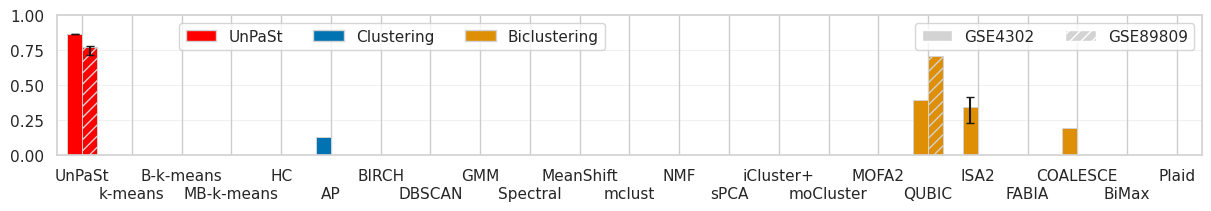

In [10]:
dfs = pd.read_csv("asthma_performances_Fig3.tsv.gz",sep="\t",index_col=0)
plot_dual_dataset_bars(
    dfs.loc[dfs['parameters']=="optimized_ARI"],  # your dataframe with columns: method, dataset, PAM50
    clust_methods=clust_methods,
    biclust_methods=biclust_methods,
    dataset_order=("GSE4302","GSE89809"),#("METABRIC","TCGA-BRCA"),
    group_colors=group_colors,
    fig_size=(12, 2),
    ylim=(0, 1),
    ylabel="",
    p_col = "ARI"
)
for ext in ["png","svg","pdf"]:
    plt.savefig("../../img/Fig3/Fig3c_v4."+ext,dpi = 300)

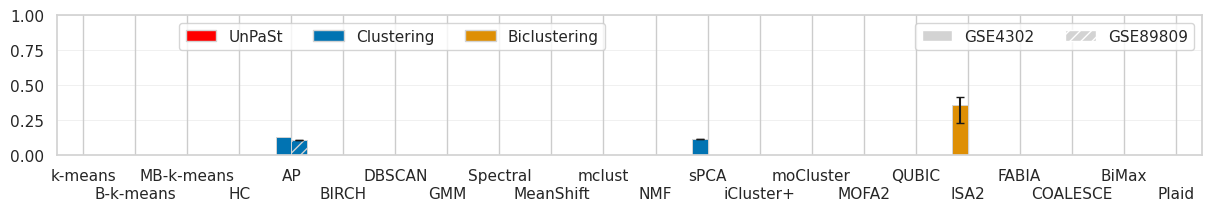

In [11]:
plot_dual_dataset_bars(
    dfs.loc[dfs['parameters']=="default"],  # your dataframe with columns: method, dataset, PAM50
    clust_methods=clust_methods,
    biclust_methods=biclust_methods,
    dataset_order=("GSE4302","GSE89809"),#("METABRIC","TCGA-BRCA"),
    group_colors=group_colors,
    fig_size=(12, 2),
    ylim=(0, 1),
    ylabel="",
    p_col = "ARI"
)
for ext in ["png","svg","pdf"]:
    plt.savefig("../../img/Fig3/Fig3d_v4."+ext,dpi = 300)

### Figs. S3, S4, S5, S6 - TBD